In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL
import pathlib
from pathlib import Path
import os
import cv2
print (tf.__version__)
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras.models import Sequential


2.9.0


In [2]:
directory = 'MathSymbols'
files = Path(directory).glob('*')
img_height = 45
img_width = 45
batch_size = 10

In [3]:
tf.keras.utils.image_dataset_from_directory(
    'MathSymbols',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(45, 45),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)


Found 375974 files belonging to 82 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 45, 45, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'MathSymbols',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(45, 45),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  'MathSymbols',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(45, 45),
  batch_size=batch_size)

Found 375974 files belonging to 82 classes.
Using 300780 files for training.
Found 375974 files belonging to 82 classes.
Using 75194 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['!', '(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'C', 'Delta', 'G', 'H', 'M', 'N', 'R', 'S', 'T', 'X', '[', ']', 'alpha', 'ascii_124', 'b', 'beta', 'cos', 'd', 'div', 'e', 'exists', 'f', 'forall', 'forward_slash', 'gamma', 'geq', 'gt', 'i', 'in', 'infty', 'int', 'j', 'k', 'l', 'lambda', 'ldots', 'leq', 'lim', 'log', 'lt', 'mu', 'neq', 'o', 'p', 'phi', 'pi', 'pm', 'prime', 'q', 'rightarrow', 'sigma', 'sin', 'sqrt', 'sum', 'tan', 'theta', 'times', 'u', 'v', 'w', 'y', 'z', '{', '}']


InvalidArgumentError: slice index 10 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

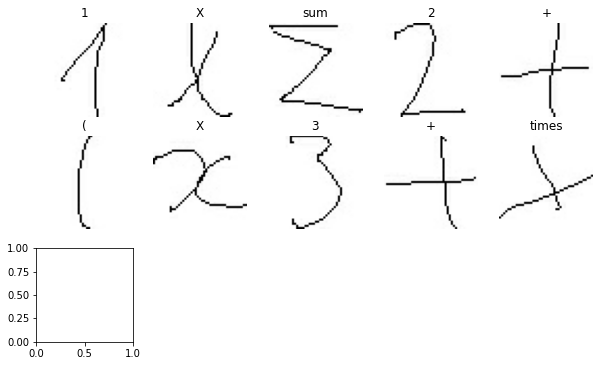

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.Rescaling(1./255)


In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [15]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 45, 45, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 45, 45, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        1

In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

Epoch 1/50
30078/30078 [==============================] - 461s 15ms/step - loss: 0.3361 - accuracy: 0.9064 - val_loss: 0.1835 - val_accuracy: 0.9460
Epoch 2/50
30078/30078 [==============================] - 608s 20ms/step - loss: 0.1489 - accuracy: 0.9540 - val_loss: 0.1424 - val_accuracy: 0.9577
Epoch 3/50
30078/30078 [==============================] - 600s 20ms/step - loss: 0.1123 - accuracy: 0.9647 - val_loss: 0.1139 - val_accuracy: 0.9642
Epoch 4/50
30078/30078 [==============================] - 595s 20ms/step - loss: 0.0940 - accuracy: 0.9697 - val_loss: 0.1271 - val_accuracy: 0.9615
Epoch 5/50
30078/30078 [==============================] - 596s 20ms/step - loss: 0.0831 - accuracy: 0.9736 - val_loss: 0.0958 - val_accuracy: 0.9737
Epoch 6/50
30078/30078 [==============================] - 597s 20ms/step - loss: 0.0769 - accuracy: 0.9757 - val_loss: 0.1119 - val_accuracy: 0.9656
Epoch 7/50
30078/30078 [==============================] - 590s 20ms/step - loss: 0.0735 - accuracy: 0.9772

In [106]:
history.history

{'loss': [0.3862953782081604],
 'accuracy': [0.8942615985870361],
 'val_loss': [0.19016830623149872],
 'val_accuracy': [0.943865180015564]}

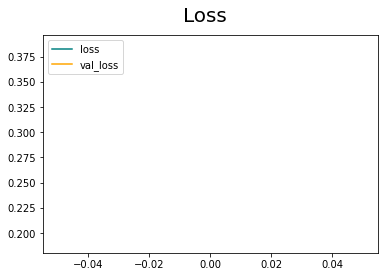

In [107]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

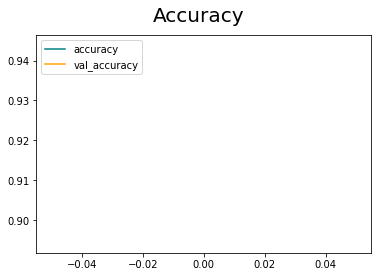

In [108]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [109]:
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *

In [72]:
width = 45  # canvas width
height = 45 # canvas height
center = width/2
white = (255, 255, 255) # canvas back

def save():
    # save image to hard drive
    filename = "user_input.png"
    output_image.save(filename)

def paint(event):
    x1, y1 = (event.x - 1), (event.y - 1)
    x2, y2 = (event.x + 1), (event.y + 1)
    canvas.create_oval(x1, y1, x2, y2, fill="black",width=2)
    draw.line([x1, y1, x2, y2],fill="black",width=2)

master = Tk()

# create a tkinter canvas to draw on
canvas = Canvas(master, width=width, height=height, bg='white')
canvas.pack()

# create an empty PIL image and draw object to draw on
output_image = PIL.Image.new("RGB", (width, height), white)
draw = ImageDraw.Draw(output_image)
canvas.pack(expand=YES, fill=BOTH)
canvas.bind("<B1-Motion>", paint)

# add a button to save the image
button=Button(text="save",command=save)
button.pack()

master.mainloop()

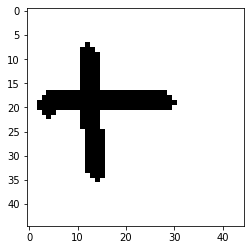

In [3]:
from PIL import Image
from numpy import asarray
import cv2
image =cv2.imread('user_input.png')
plt.imshow(image)
plt.show()


In [4]:
img = tf.keras.utils.load_img('user_input.png',color_mode = "grayscale")
img
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
model.predict(img_array)

NameError: name 'model' is not defined

In [112]:
predictions_array = model.predict(np.expand_dims(image/255, 0))
print (predictions_array)

1/1 [==============================] - 0s 77ms/step
[[-1.74279079e+01 -1.07106447e+01 -1.63100414e+01 -4.42839289e+00
  -8.15655613e+00 -5.80328131e+00 -1.98138392e+00 -7.73647308e+00
  -2.36928368e+00 -9.08413982e+00 -2.58174586e+00 -1.41530871e+00
  -3.22236323e+00 -4.25333357e+00  1.39567629e-01 -5.73723602e+00
  -1.23683710e+01  2.67420244e+00 -7.72528315e+00 -2.02265358e+00
   2.22239375e+00  1.22820936e-01  1.58553100e+00 -3.83617401e-01
  -1.90527499e-01 -4.48150921e+00 -2.64685678e+00 -2.54565501e+00
  -6.26458931e+00 -1.43244381e+01 -5.13829136e+00 -1.26755571e+01
   4.20395041e+00 -7.84511387e-01 -1.50522220e+00 -1.18413365e+00
  -1.04686232e+01 -2.37626600e+00 -9.46695900e+00 -2.04508162e+00
  -2.44308233e+00 -8.02096558e+00 -3.57791710e+00 -4.64703655e+00
  -1.04487257e+01 -3.11686897e+00 -8.06030941e+00  1.07102835e+00
  -1.43804045e+01 -5.28561974e+00  1.65860784e+00 -2.78752732e+00
  -7.07458496e+00 -1.40331459e+01 -9.82696438e+00  1.87427282e+00
   3.52424169e+00 -1.000

In [113]:
score = tf.nn.softmax(predictions_array[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to b with a 37.40 percent confidence.
